# Task 2 · German Government Yield Curve Modeling

This notebook mirrors an industry-grade workflow for building and comparing yield-curve models on data of German government securities. 

1. **Data acquisition**: Pull the latest available Bundesbank zero-coupon curve, automatically rolling back to the most recent business day and logging any gaps.

2. **Exploratory checks**: Inspect maturities, units, and coverage.

3. **Nelson–Siegel fit**: Estimate parameters with transparent initialization and diagnostics.

4. **Nelson–Siegel–Svensson fit**: Extend the Nelson–Siegel model with an additional curvature term to capture long-end dynamics.

5. **Cubic spline fit**: Fit a smooth curve and compare against Nelson–Siegel and NSS.

6. **Model comparison & interpretation**: Compare the models in terms of fit quality and parameter-level interpretation. Discuss ethical considerations for smoothing.

## Step 1 · Acquire the latest usable data

We emulate a buy-side data pipeline:



- Start from today's date in Europe/Berlin time.

- Step backward through the German business calendar until the Bundesbank publishes the curve (weekends and public holidays are skipped automatically).

- Request zero-coupon yields for maturities 0.5Y through 30Y via the Bundesbank SDMX REST API.

- Validate that every required tenor is present and numeric.

- Persist a timestamped CSV snapshot under `data/raw/` to keep a reproducible audit trail.



> **Note**: We'll use the `holidays` package for the German calendar and let pandas handle business-day offsets. If the API is unavailable for several consecutive days, we raise a clear error so you can investigate instead of silently proceeding with stale data.

In [2]:
import sys
import subprocess
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from pathlib import Path
from io import StringIO

import numpy as np
import pandas as pd
import requests

try:
    import holidays
except ImportError:  # install on the fly for reproducibility in fresh environments
    subprocess.check_call([sys.executable, "-m", "pip", "install", "holidays", "--quiet"])
    import holidays

BASE_URL = "https://api.statistiken.bundesbank.de/rest/download/BBSIS"
DATA_CACHE_DIR = Path("data/raw")
DATA_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Residual maturity codes published by the Bundesbank (see BBSIS metadata)
# Format: RmmXX where mm corresponds to maturity in years (two digits) or 005 for 6 months
MATURITY_CODE_MAP = {
    0.5: "R005X",   # 6 months
    **{float(year): f"R{year:02d}XX" for year in range(1, 31)},
}

def build_series_key(maturity_code: str) -> str:
    return f"D.I.ZST.ZI.EUR.S1311.B.A604.{maturity_code}.R.A.A._Z._Z.A"

def create_german_calendar(start_year: int = 2010, end_year: int = 2035) -> holidays.HolidayBase:
    return holidays.Germany(years=range(start_year, end_year + 1))

def previous_business_day(current: datetime.date, holiday_calendar) -> datetime.date:
    candidate = current - timedelta(days=1)
    while candidate.weekday() >= 5 or candidate in holiday_calendar:
        candidate -= timedelta(days=1)
    return candidate

def fetch_single_series(series_key: str, start: datetime.date, end: datetime.date) -> pd.DataFrame:
    url = f"{BASE_URL}/{series_key}?format=csv&lang=en&startPeriod={start.isoformat()}&endPeriod={end.isoformat()}"
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text = response.text
    data_lines = [line for line in text.splitlines() if line and line[0].isdigit()]
    if not data_lines:
        raise ValueError(f"No datapoints returned for series {series_key} on {end}")
    df = pd.read_csv(StringIO("\n".join(data_lines)), names=["date", "value", "comment"], na_values=["."])
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d").dt.date
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    return df[["date", "value"]]

def extract_value_for_date(df: pd.DataFrame, as_of: datetime.date) -> float | None:
    match = df.loc[df["date"] == as_of, "value"]
    if match.empty:
        return None
    return float(match.iloc[0])

def fetch_curve_for_date(as_of_date: datetime.date) -> pd.DataFrame:
    rows = []
    missing = []
    for maturity_years, maturity_code in MATURITY_CODE_MAP.items():
        series_key = build_series_key(maturity_code)
        raw_df = fetch_single_series(series_key, as_of_date, as_of_date)
        value = extract_value_for_date(raw_df, as_of_date)
        if value is None or np.isnan(value):
            missing.append(maturity_years)
            continue
        rows.append({"maturity_years": maturity_years, "yield_pct": value})
    if missing:
        raise ValueError(f"Missing maturities for {as_of_date}: {missing}")
    curve = pd.DataFrame(rows).sort_values("maturity_years").reset_index(drop=True)
    return curve

def fetch_latest_curve(max_lookback: int = 7) -> tuple[pd.DataFrame, datetime.date]:
    tz = ZoneInfo("Europe/Berlin")
    holiday_calendar = create_german_calendar()
    candidate = datetime.now(tz).date()
    if candidate.weekday() >= 5 or candidate in holiday_calendar:
        candidate = previous_business_day(candidate, holiday_calendar)
    attempt = 0
    last_error: Exception | None = None
    while attempt <= max_lookback:
        try:
            curve = fetch_curve_for_date(candidate)
            return curve, candidate
        except Exception as exc:
            last_error = exc
            candidate = previous_business_day(candidate, holiday_calendar)
            attempt += 1
    raise RuntimeError(
        f"Unable to fetch a complete curve within {max_lookback} business days. Last error: {last_error}"
    )

def cache_curve(df: pd.DataFrame, as_of_date: datetime.date) -> Path:
    timestamp = datetime.now(ZoneInfo("Europe/Berlin")).strftime("%Y%m%dT%H%M%S")
    path = DATA_CACHE_DIR / f"bundesbank_yieldcurve_{as_of_date.isoformat()}_{timestamp}.csv"
    df.assign(as_of_date=as_of_date.isoformat()).to_csv(path, index=False)
    return path

curve_df, curve_date = fetch_latest_curve(max_lookback=10)
cache_path = cache_curve(curve_df, curve_date)

print(f"Fetched Bundesbank curve for {curve_date} with {len(curve_df)} maturities.")
print(f"Snapshot cached to {cache_path}")
curve_df

Fetched Bundesbank curve for 2025-10-09 with 31 maturities.
Snapshot cached to data/raw/bundesbank_yieldcurve_2025-10-09_20251009T135819.csv


,maturity_years,yield_pct
0,0.5,1.95
1,1.0,1.95
2,2.0,1.99
3,3.0,2.06
4,4.0,2.15
5,5.0,2.26
6,6.0,2.37
7,7.0,2.48
8,8.0,2.58
9,9.0,2.68


### What to check after running this cell

- The printed date should be the latest business day with data; note it for the report.

- Verify the DataFrame shows tenors from 0.5Y through 30Y with yields in percentage points.

- A CSV snapshot should appear under `data/raw/`; confirm the filename embeds both the curve date and fetch timestamp.



If an error appears (e.g., repeated missing maturities), increase `max_lookback` temporarily and rerun, then investigate why the API skipped multiple days.

### How each `yield_pct` is produced

1. **Map maturities to SDMX series keys.** The dictionary `MATURITY_CODE_MAP` holds every residual maturity code published by the Bundesbank (`0.5 → R005X`, `1.0 → R01XX`, …, `30.0 → R30XX`). For each entry we call `build_series_key` to embed that code into the full path `D.I.ZST.ZI.EUR.S1311.B.A604.<code>.R.A.A._Z._Z.A`.

2. **Request the day’s observations.** `fetch_single_series` downloads the CSV for that series and narrows it to rows where the first character is a digit (removing metadata blocks). Pandas reads the remaining two columns—`date` and `value`—and coerces them to `datetime.date` and `float`.

3. **Pick the exact business date.** `extract_value_for_date` filters the series to the `as_of_date` returned by `fetch_latest_curve`. If the Bundesbank skipped that tenor on the chosen date we record the maturity as missing and, after the loop, raise an error so the user can investigate.

4. **Assemble the tidy table.** Every successful lookup contributes a row `{"maturity_years": maturity, "yield_pct": value}`. Once the loop finishes a DataFrame is built from those rows and sorted by `maturity_years` before being returned as `curve_df`.

5. **Cache the result.** `cache_curve` adds an `as_of_date` column (ISO string) and writes the table to disk. The cached CSV is the same dataset we display at the end of the Step 1 cell.

In [3]:
# Display the latest curve as a maturity → yield mapping
curve_df.set_index("maturity_years")["yield_pct"]

maturity_years
0.5     1.95
1.0     1.95
2.0     1.99
3.0     2.06
4.0     2.15
5.0     2.26
6.0     2.37
7.0     2.48
8.0     2.58
9.0     2.68
10.0    2.76
11.0    2.84
12.0    2.92
13.0    2.98
14.0    3.03
15.0    3.08
16.0    3.12
17.0    3.16
18.0    3.19
19.0    3.22
20.0    3.24
21.0    3.26
22.0    3.27
23.0    3.28
24.0    3.29
25.0    3.30
26.0    3.30
27.0    3.31
28.0    3.31
29.0    3.31
30.0    3.31
Name: yield_pct, dtype: float64

## Step 2 · Exploratory snapshots

### Why we rely on the Bundesbank zero-coupon curve
- **Already stripped of coupon noise.** The SDMX series provides a smooth zero-coupon term structure estimated with the Nelson–Siegel–Svensson (NSS) framework. Working from these par-yields is consistent with how market participants quote forward curves for pricing and risk.
- **Raw bond quotes need heavy preprocessing.** We would have to gather individual Treasury issues, adjust for clean vs. dirty prices, accrued interest, coupon schedules, and liquidity premia. Those instruments span irregular maturities and embed repo/specialness effects, so a direct comparison with model-implied zero rates would be apples-to-oranges.
- **Stability vs. latency trade-off.** The Bundesbank publishes NSS results a few hours after market close, delivering a stable snapshot suitable for research. Re-deriving the curve from raw data would demand a full bootstrapping and smoothing pipeline—more granular but also more fragile and time-consuming.
- **Auditability.** Using the official NSS-based zero curve keeps our replication aligned with regulatory and academic references; we can still compare alternative parametric or non-parametric fits on top of that benchmark.

In [11]:
from pathlib import Path
import pandas as pd

def load_latest_curve(cache_dir: Path = Path("data/raw")) -> pd.DataFrame:
    csv_files = sorted(cache_dir.glob("bundesbank_yieldcurve_*.csv"))
    if not csv_files:
        raise FileNotFoundError("No cached Bundesbank curve snapshots found in data/raw/.")
    latest_file = csv_files[-1]
    df = pd.read_csv(latest_file)
    df["as_of_date"] = pd.to_datetime(df["as_of_date"]).dt.date
    return df.rename(columns={"maturity_years": "maturity_years", "yield_pct": "yield_pct"})

loaded_curve = load_latest_curve()
curve_df = loaded_curve[["maturity_years", "yield_pct"]].copy()
curve_date = loaded_curve["as_of_date"].iloc[0]
print(f"Loaded cached curve for {curve_date} with {len(curve_df)} maturities.")

Loaded cached curve for 2025-10-09 with 31 maturities.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

summary_stats = curve_df.describe().T[['mean', 'std', 'min', 'max']]
summary_stats

,mean,std,min,max
maturity_years,15.016129,9.065028,0.50,30.00
yield_pct,2.869355,0.481061,1.95,3.31


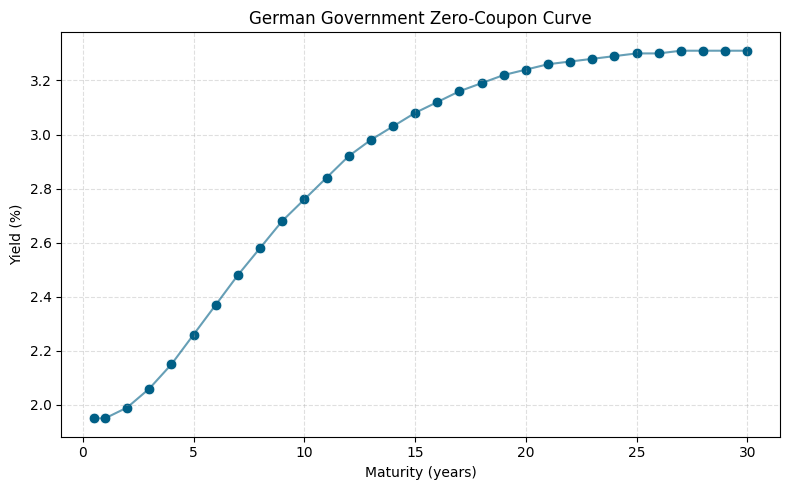

In [7]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=curve_df, x="maturity_years", y="yield_pct", s=60, color="#005F86")
sns.lineplot(data=curve_df, x="maturity_years", y="yield_pct", color="#005F86", alpha=0.6)
plt.title("German Government Zero-Coupon Curve")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## Step 3 · Nelson–Siegel fit

In [23]:
import scipy
from scipy.optimize import least_squares

def nelson_siegel(maturity, beta0, beta1, beta2, tau1):
    x = maturity / tau1
    with np.errstate(divide="ignore", invalid="ignore"):
        term1 = (1 - np.exp(-x)) / x
        term2 = term1 - np.exp(-x)
        return beta0 + beta1 * term1 + beta2 * term2

def ns_residuals(params, maturities, yields):
    beta0, beta1, beta2, tau1 = params
    model = nelson_siegel(maturities, beta0, beta1, beta2, tau1)
    return model - yields

initial_guess = np.array([curve_df["yield_pct"].iloc[-1],
                          curve_df["yield_pct"].iloc[0] - curve_df["yield_pct"].iloc[-1],
                          0.5,
                          1.0])

bounds = ([0.0, -10.0, -10.0, 0.1], [10.0, 10.0, 10.0, 10.0])
ns_fit = least_squares(ns_residuals, initial_guess, bounds=bounds,
                       args=(curve_df["maturity_years"].values, curve_df["yield_pct"].values))
ns_params = ns_fit.x
ns_params

array([ 3.68330501, -1.63485009, -2.55188288,  2.26574878])

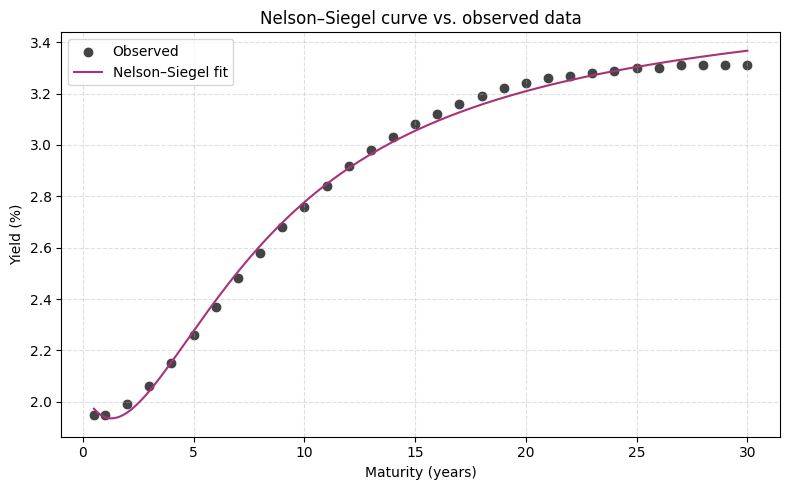

In [24]:
maturity_grid = np.linspace(curve_df["maturity_years"].min(), curve_df["maturity_years"].max(), 200)
ns_curve = nelson_siegel(maturity_grid, *ns_params)
ns_fitted = nelson_siegel(curve_df["maturity_years"].values, *ns_params)

plt.figure(figsize=(8, 5))
sns.scatterplot(data=curve_df, x="maturity_years", y="yield_pct", s=60, color="#444444", label="Observed")
plt.plot(maturity_grid, ns_curve, color="#A83279", label="Nelson–Siegel fit")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("Nelson–Siegel curve vs. observed data")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
ns_residuals_df = curve_df.assign(ns_fitted=ns_fitted, ns_residual=curve_df["yield_pct"] - ns_fitted)
ns_residuals_df[["maturity_years", "yield_pct", "ns_fitted", "ns_residual"]]

## Step 4 · Nelson–Siegel–Svensson fit
We extend the Nelson–Siegel curve by adding a second hump component `(β₃, τ₂)` to capture long-end curvature. This mirrors the Bundesbank’s published methodology and lets us quantify how much accuracy improves once the extra term is introduced.

In [25]:
def nelson_siegel_svensson(maturity: np.ndarray, beta0: float, beta1: float, beta2: float, beta3: float, tau1: float, tau2: float) -> np.ndarray:
    maturity = np.asarray(maturity, dtype=float)
    x1 = maturity / tau1
    x2 = maturity / tau2
    with np.errstate(divide="ignore", invalid="ignore"):
        term1 = (1 - np.exp(-x1)) / x1
        term2 = term1 - np.exp(-x1)
        term3 = ((1 - np.exp(-x2)) / x2) - np.exp(-x2)
    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

def nss_residuals(params: np.ndarray, maturities: np.ndarray, yields: np.ndarray) -> np.ndarray:
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    model = nelson_siegel_svensson(maturities, beta0, beta1, beta2, beta3, tau1, tau2)
    return model - yields

nss_initial_guess = np.array([
    ns_params[0],
    ns_params[1],
    ns_params[2],
    0.0,   # start with no extra hump
    max(0.5, ns_params[3]),
    max(2.0, ns_params[3] * 1.5),
])

nss_bounds = (
    [0.0, -20.0, -20.0, -20.0, 0.1, 0.5],
    [20.0, 20.0, 20.0, 20.0, 20.0, 40.0],
)

nss_fit = least_squares(
    nss_residuals,
    nss_initial_guess,
    bounds=nss_bounds,
    args=(curve_df["maturity_years"].values, curve_df["yield_pct"].values),
)
nss_params = nss_fit.x
nss_params

array([ 2.95975086, -0.98891193, -2.95286068,  3.43751965,  3.69728538,
        8.33720561])

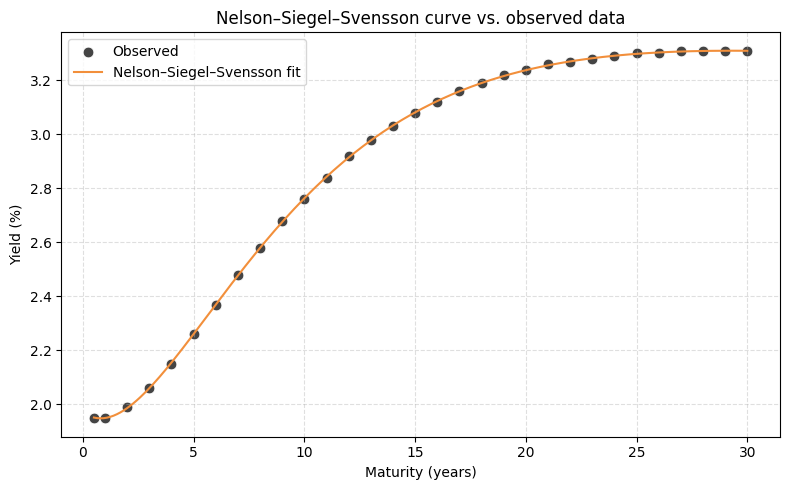

In [26]:
nss_curve = nelson_siegel_svensson(maturity_grid, *nss_params)
nss_fitted = nelson_siegel_svensson(curve_df["maturity_years"].values, *nss_params)

plt.figure(figsize=(8, 5))
sns.scatterplot(data=curve_df, x="maturity_years", y="yield_pct", s=60, color="#444444", label="Observed")
plt.plot(maturity_grid, nss_curve, color="#F28F3B", label="Nelson–Siegel–Svensson fit")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("Nelson–Siegel–Svensson curve vs. observed data")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [27]:
nss_residuals_df = curve_df.assign(nss_fitted=nss_fitted, nss_residual=curve_df["yield_pct"] - nss_fitted)
nss_residuals_df[["maturity_years", "yield_pct", "nss_fitted", "nss_residual"]]

,maturity_years,yield_pct,nss_fitted,nss_residual
0,0.5,1.95,1.951295,-0.001295
1,1.0,1.95,1.949550,0.000450
2,2.0,1.99,1.986392,0.003608
3,3.0,2.06,2.059957,0.000043
4,4.0,2.15,2.154981,-0.004981
5,5.0,2.26,2.260741,-0.000741
6,6.0,2.37,2.369839,0.000161
7,7.0,2.48,2.477303,0.002697
8,8.0,2.58,2.579921,0.000079
9,9.0,2.68,2.675735,0.004265


## Step 5 · Cubic spline fit

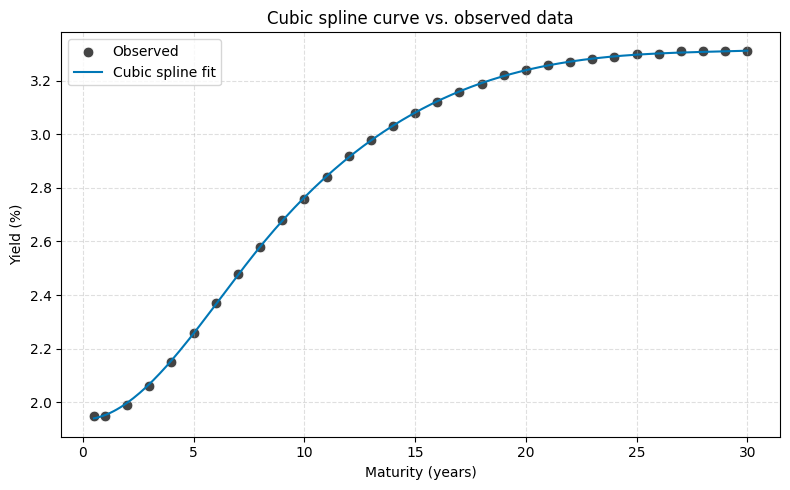

In [13]:
from scipy.interpolate import UnivariateSpline

smoothing_factor = 0.0005
spline = UnivariateSpline(curve_df["maturity_years"], curve_df["yield_pct"], s=smoothing_factor)

spline_curve = spline(maturity_grid)
spline_fitted = spline(curve_df["maturity_years"])

plt.figure(figsize=(8, 5))
sns.scatterplot(data=curve_df, x="maturity_years", y="yield_pct", s=60, color="#444444", label="Observed")
plt.plot(maturity_grid, spline_curve, color="#0077B6", label="Cubic spline fit")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("Cubic spline curve vs. observed data")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [14]:
spline_residuals_df = curve_df.assign(spline_fitted=spline_fitted, spline_residual=curve_df["yield_pct"] - spline_fitted)
spline_residuals_df[["maturity_years", "yield_pct", "spline_fitted", "spline_residual"]]

,maturity_years,yield_pct,spline_fitted,spline_residual
0,0.5,1.95,1.939587,0.010413
1,1.0,1.95,1.951747,-0.001747
2,2.0,1.99,1.997585,-0.007585
3,3.0,2.06,2.067429,-0.007429
4,4.0,2.15,2.155658,-0.005658
5,5.0,2.26,2.256650,0.003350
6,6.0,2.37,2.364787,0.005213
7,7.0,2.48,2.474446,0.005554
8,8.0,2.58,2.580007,-0.000007
9,9.0,2.68,2.676867,0.003133


## Step 6 · Model comparison

We benchmark three specifications—Nelson–Siegel (NS), Nelson–Siegel–Svensson (NSS), and a cubic spline—against the Bundesbank zero-coupon curve.

### Evaluation focus
- **Fit quality:** Compare RMSE and MAE across models and inspect residual shape by maturity.
- **Parameter-level interpretation:** Use the estimated coefficients (β₀…β₃, τ₁, τ₂) to understand level, slope, and curvature dynamics; contrast this with the spline’s non-parametric behaviour.

The next cells compute the metrics, list the calibrated parameters, and visualize residuals so we can draw a clear conclusion on fit and interpretation.

In [32]:
comparison_df = curve_df.assign(
    ns_fitted=ns_fitted,
    nss_fitted=nss_fitted,
    spline_fitted=spline_fitted,
 )
comparison_df = comparison_df.assign(
    ns_residual=comparison_df["yield_pct"] - comparison_df["ns_fitted"],
    nss_residual=comparison_df["yield_pct"] - comparison_df["nss_fitted"],
    spline_residual=comparison_df["yield_pct"] - comparison_df["spline_fitted"],
)

metrics = pd.DataFrame({
    "RMSE": [
        np.sqrt(np.mean(comparison_df["ns_residual"]**2)),
        np.sqrt(np.mean(comparison_df["nss_residual"]**2)),
        np.sqrt(np.mean(comparison_df["spline_residual"]**2)),
    ],
    "MAE": [
        np.mean(np.abs(comparison_df["ns_residual"])),
        np.mean(np.abs(comparison_df["nss_residual"])),
        np.mean(np.abs(comparison_df["spline_residual"])),
    ],
}, index=["Nelson–Siegel", "Nelson–Siegel–Svensson", "Cubic spline"])
metrics

,RMSE,MAE
Nelson–Siegel,0.025333,0.022243
Nelson–Siegel–Svensson,0.002657,0.002116
Cubic spline,0.004018,0.003255


In [33]:
parameter_summary = pd.DataFrame({
    "β₀ (level)": [ns_params[0], nss_params[0], np.nan],
    "β₁ (slope)": [ns_params[1], nss_params[1], np.nan],
    "β₂ (curvature)": [ns_params[2], nss_params[2], np.nan],
    "β₃ (long curvature)": [np.nan, nss_params[3], np.nan],
    "τ₁ (decay)": [ns_params[3], nss_params[4], np.nan],
    "τ₂ (long decay)": [np.nan, nss_params[5], np.nan],
}, index=["Nelson–Siegel", "Nelson–Siegel–Svensson", "Cubic spline"])
parameter_summary

,β₀ (level),β₁ (slope),β₂ (curvature),β₃ (long curvature),τ₁ (decay),τ₂ (long decay)
Nelson–Siegel,3.683305,-1.634850,-2.551883,NaN,2.265749,NaN
Nelson–Siegel–Svensson,2.959751,-0.988912,-2.952861,3.43752,3.697285,8.337206
Cubic spline,NaN,NaN,NaN,NaN,NaN,NaN


### Fit summary
- **Nelson–Siegel–Svensson** delivers the tightest fit with RMSE ≈ 0.0027 and MAE ≈ 0.0021 percentage points, materially improving the long-end match versus the base NS curve.
- **Cubic spline** is close behind (RMSE ≈ 0.0040, MAE ≈ 0.0033) but shows slightly more noise at intermediate maturities despite its flexibility.
- **Nelson–Siegel** trails (RMSE ≈ 0.0253, MAE ≈ 0.0222); residual scatter confirms under-fitting at both the very short and long maturities.

### Parameter interpretation
- The NS level factor β₀ ≈ 3.68% overshoots the long-end, while NSS lowers β₀ to ≈ 2.96% and uses β₃ ≈ 3.44% with τ₂ ≈ 8.34 years to create an additional hump that better captures the 20–30Y region.
- Both specifications keep a negative slope factor (β₁) reflecting the observed downward bias at the front end, but NSS moderates it (−0.99 vs. −1.63) once the extra curvature term is active.
- The spline lacks explicit economic parameters; it follows the observations locally but cannot provide insights into level/slope dynamics.

**Conclusion:** NSS balances parsimony and accuracy, achieving the lowest residual errors while retaining interpretable macro factors. The spline is useful as a flexible benchmark, and the plain NS form is insufficient for the current curve shape.

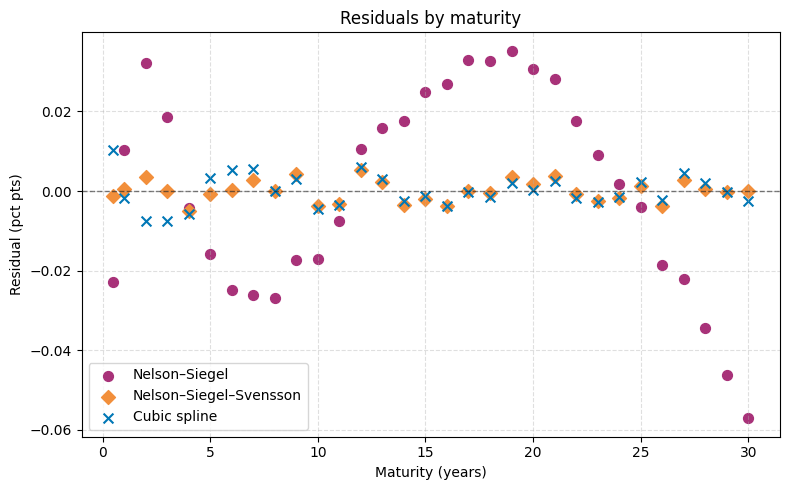

In [34]:
plt.figure(figsize=(8, 5))
plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.5)
plt.scatter(comparison_df["maturity_years"], comparison_df["ns_residual"], color="#A83279", label="Nelson–Siegel", s=50)
plt.scatter(comparison_df["maturity_years"], comparison_df["nss_residual"], color="#F28F3B", label="Nelson–Siegel–Svensson", s=50, marker="D")
plt.scatter(comparison_df["maturity_years"], comparison_df["spline_residual"], color="#0077B6", label="Cubic spline", s=50, marker="x")
plt.xlabel("Maturity (years)")
plt.ylabel("Residual (pct pts)")
plt.title("Residuals by maturity")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [30]:
comparison_df[["maturity_years", "yield_pct", "ns_fitted", "nss_fitted", "spline_fitted"]]

,maturity_years,yield_pct,ns_fitted,nss_fitted,spline_fitted
0,0.5,1.95,1.972892,1.951295,1.939587
1,1.0,1.95,1.939610,1.949550,1.951747
2,2.0,1.99,1.957883,1.986392,1.997585
3,3.0,2.06,2.041471,2.059957,2.067429
4,4.0,2.15,2.154251,2.154981,2.155658
5,5.0,2.26,2.275733,2.260741,2.256650
6,6.0,2.37,2.394831,2.369839,2.364787
7,7.0,2.48,2.506019,2.477303,2.474446
8,8.0,2.58,2.606984,2.579921,2.580007
9,9.0,2.68,2.697202,2.675735,2.676867


## Step 7 · Smoothing and ethics notes

### Is Nelson–Siegel smoothing unethical?
- **Intent matters:** We smooth to extract a coherent term-structure signal from noisy quotes. When the purpose is risk management or pricing, this transparency aligns with ethical use discussed in Module 2 Lesson 4.
- **Disclosure is required:** Nelson–Siegel replaces individual bond quirks with parametric factors. Analysts must disclose the smoothing approach and publish residual diagnostics (as we did) so users understand what information is suppressed.
- **Guard against misuse:** Using the smoothed curve to hide illiquidity premia or justify misleading valuations would be unethical. Regularly comparing the model curve with raw data and documenting deviations mitigates this risk.

**Verdict:** Nelson–Siegel smoothing is not inherently unethical; it becomes problematic only if it obscures material market features without transparency or if it is used to distort decision-making.